In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import ticker
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import BoundaryNorm
from netCDF4 import Dataset



Bad key "text.kerning_factor" on line 4 in
/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#"""
region     = 'CONUS'
ilon_start =  45
ilon_end   = 120
ilat_start = 110
ilat_end   = 150
#"""

isl        = 1
YYYY_list  = [2012];
nYYYY      = len(YYYY_list)
plt.rcParams.update({'font.size': 22})
nx         = ilon_end-ilon_start + 1;
ny         = ilat_end-ilat_start + 1;


In [14]:
WWLLN_dir       = '/home/disk/eos12/wycheng/data/US/WWLLN/'
ERA5_dir        = '/home/disk/eos12/wycheng/data/US/ERA5/'
TRMM_dir        = '/home/disk/eos12/wycheng/data/US/TRMM/'
island_dir      = '/home/disk/eos9/wycheng/LightningMachineLearning/data/cgdata/island/'

island_fname    = 'island_1deg.nc'
ncin_island     = Dataset(island_dir+island_fname,'r')
island_in       = ncin_island.variables['island'][ilat_start:ilat_end,ilon_start:ilon_end]

nYYYY           = np.shape(YYYY_list)[0]

for iYYYY in range(nYYYY):
    YYYY = YYYY_list[iYYYY];

    WWLLN_F_fname   = 'WWLLN_'+str(YYYY)+'_F_cg_1deg3hr_US.nc'
    ERA5_cape_fname = 'ERA5_'+str(YYYY)+'_cape_cg_1deg3hr_US.nc'
    TRMM_pcp_fname  = 'TRMM_'+str(YYYY)+'_pcp_cg_1deg3hr_US.nc'

    ncin_F          = Dataset(WWLLN_dir+WWLLN_F_fname,'r')
    ncin_cape       = Dataset(ERA5_dir+ERA5_cape_fname,'r')
    ncin_pcp        = Dataset(TRMM_dir+TRMM_pcp_fname,'r')

    
    if (iYYYY==0):
        F_in        = ncin_F.variables['F'][:,:,:]
        cape_in     = ncin_cape.variables['cape'][:,:,:]
        pcp_in      = ncin_pcp.variables['pcp'][:,:,:]

    else:
        F_in        = np.append(F_in,ncin_F.variables['F'][:,:,:],axis=0)
        cape_in     = np.append(cape_in,ncin_cape.variables['cape'][:,:,:],axis=0)
        pcp_in      = np.append(pcp_in,ncin_pcp.variables['pcp'][:,:,:],axis=0)

F_in        = F_in * (1/((111.19492664455873)**2)) * (365.25*8) # turn unit into [km-2 yr-1]
sqrtcape_in = cape_in ** 0.5;

island_in3d = np.broadcast_to(island_in, F_in.shape)

In [15]:
print(island_in3d.shape)
print(F_in.shape)
print(cape_in.shape)
print(sqrtcape_in.shape)
print(pcp_in.shape)

(2928, 40, 75)
(2928, 40, 75)
(2928, 40, 75)
(2928, 40, 75)
(2928, 40, 75)


In [16]:
mask_island   = island_in3d==1;
print(mask_island.shape)
mask_normal   = 1.0*mask_island;
mask_normal   = np.where(mask_island==0, np.nan, mask_island);
print(mask_normal.shape)

(2928, 40, 75)
(2928, 40, 75)


In [17]:
clevs0          = np.arange(0,50,20)

llcrnrlon       = -135
llcrnrlat       =   20
urcrnrlon       =  -60
urcrnrlat       =   60
coastlinewidth  =    3.
coastlinecolor  = 'gray'
lat             = np.linspace(  20, 60,  ny);#np.linspace( -89.5, 89.5,ny);
lon             = np.linspace(-135,-60,  nx);#np.linspace(-179.5,179.5,nx);
lons, lats      = np.meshgrid(lon[:], lat[:]);#np.meshgrid(lon[ilon_start:ilon_end], lat[ilat_start:ilat_end])

# Normal Thunderstorm

/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


Text(0, 1.08, '[mm hr$^{-1}$]')

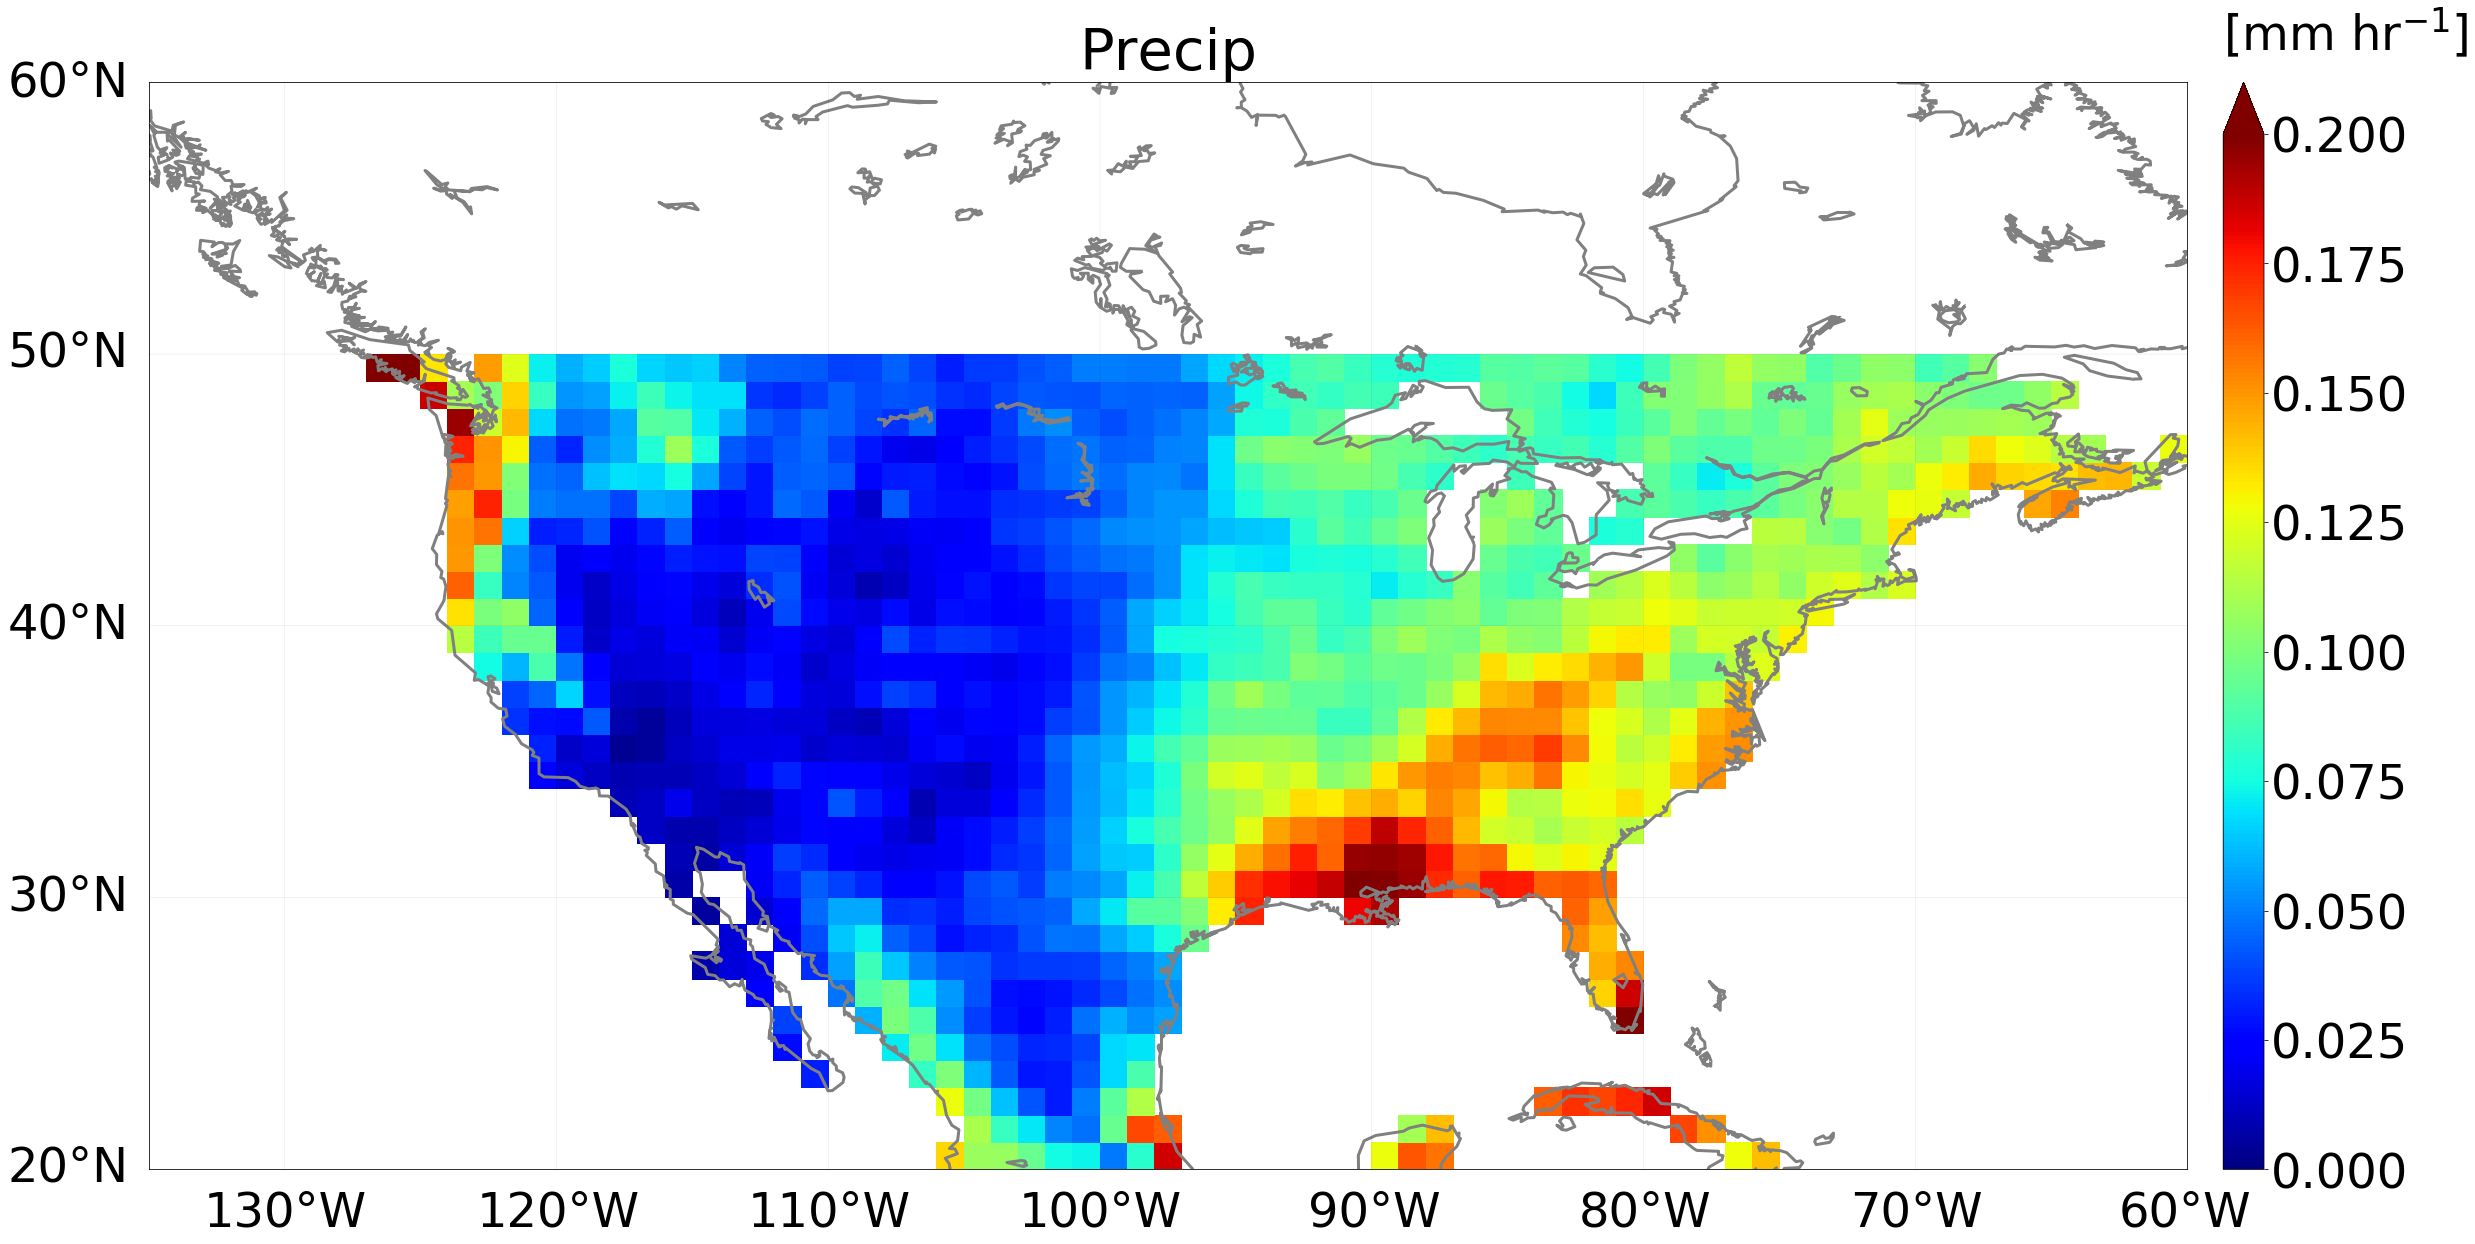

In [18]:
array = np.nanmean(pcp_in*mask_normal,axis=0)[:,:]
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(111)
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,resolution='l')
map.drawcoastlines(linewidth=coastlinewidth,color=coastlinecolor)
map.drawmeridians(np.arange(0,361,10),linewidth=0.1, labels=[0,0,0,1])
map.drawparallels(np.arange(-90,91,10), linewidth=0.1, labels=[1,0,0,0])
x, y = map(lons[:], lats[:])

cmap = plt.get_cmap('jet')
norm = BoundaryNorm(clevs0, ncolors=cmap.N, clip=True)
pcm  = plt.pcolormesh(x, y, array, cmap=cmap, norm=mcolors.PowerNorm(1.0))
plt.clim(0,0.2)
plt.title('Precip')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.5)
cbar = plt.colorbar(pcm, cax=cax,extend='max')
plt.text(0,1.08,'[mm hr$^{-1}$]')


/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


Text(0, 1.08, '[J kg$^{-1}$]')

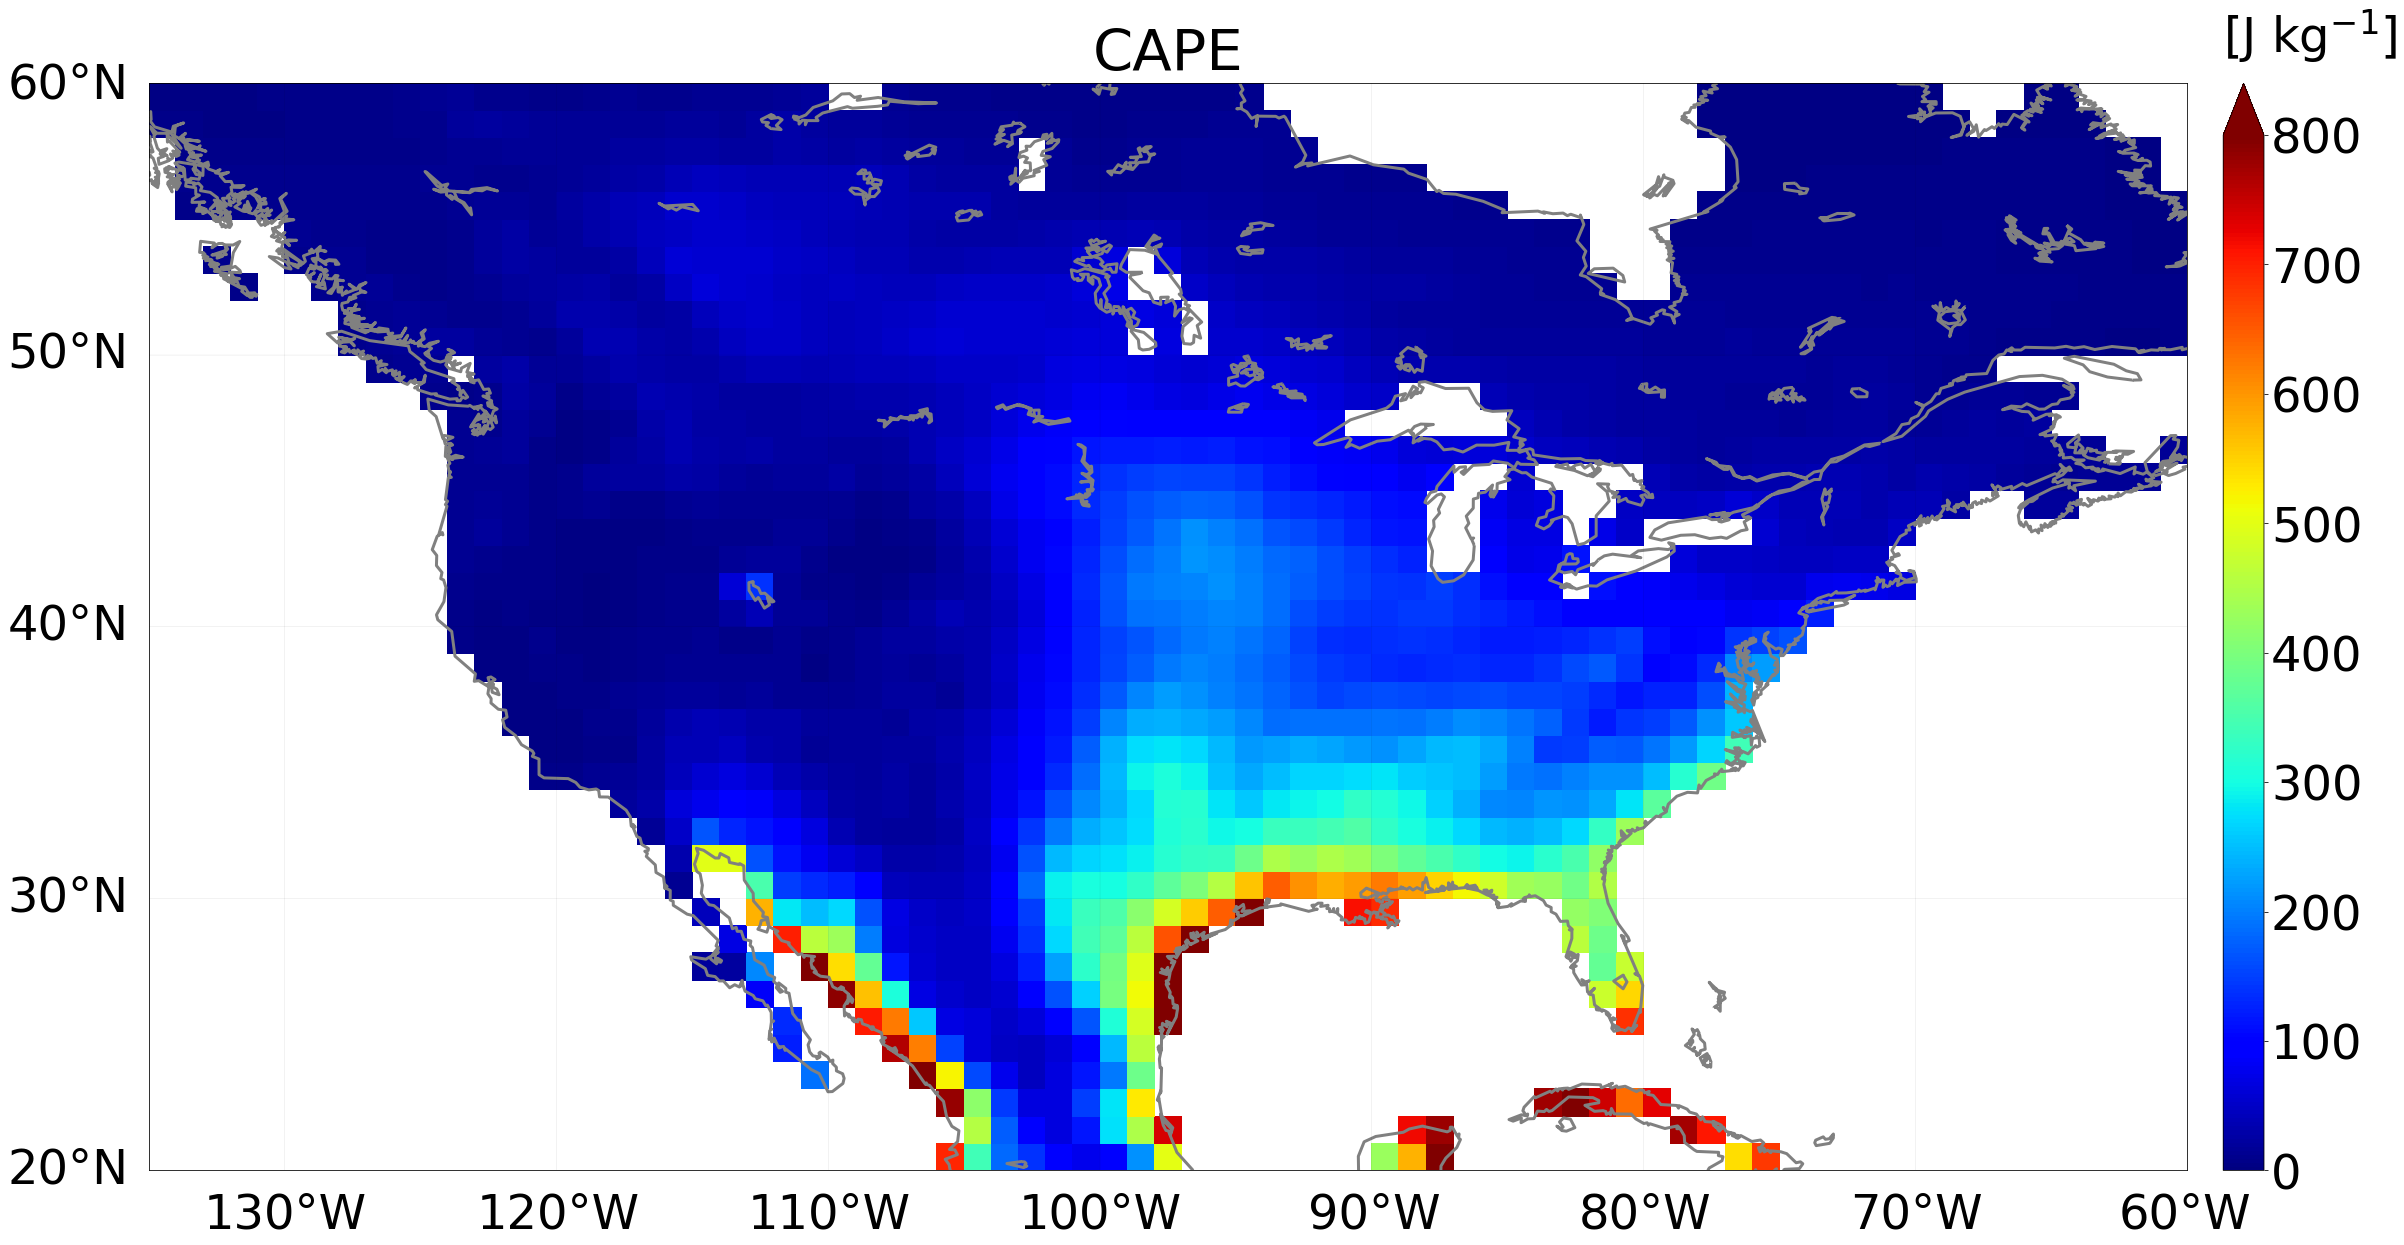

In [19]:
array = np.nanmean(cape_in*mask_normal,axis=0)[:,:]
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(111)
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,resolution='l')
map.drawcoastlines(linewidth=coastlinewidth,color=coastlinecolor)
map.drawmeridians(np.arange(0,361,10),linewidth=0.1, labels=[0,0,0,1])
map.drawparallels(np.arange(-90,91,10), linewidth=0.1, labels=[1,0,0,0])
x, y = map(lons[:], lats[:])

cmap = plt.get_cmap('jet')
norm = BoundaryNorm(clevs0, ncolors=cmap.N, clip=True)
pcm  = plt.pcolormesh(x, y, array, cmap=cmap, norm=mcolors.PowerNorm(1.0))
plt.clim(0,800)
plt.title('CAPE')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.5)
cbar = plt.colorbar(pcm, cax=cax,extend='max')
plt.text(0,1.08,'[J kg$^{-1}$]')


/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


Text(0, 1.08, '[#]')

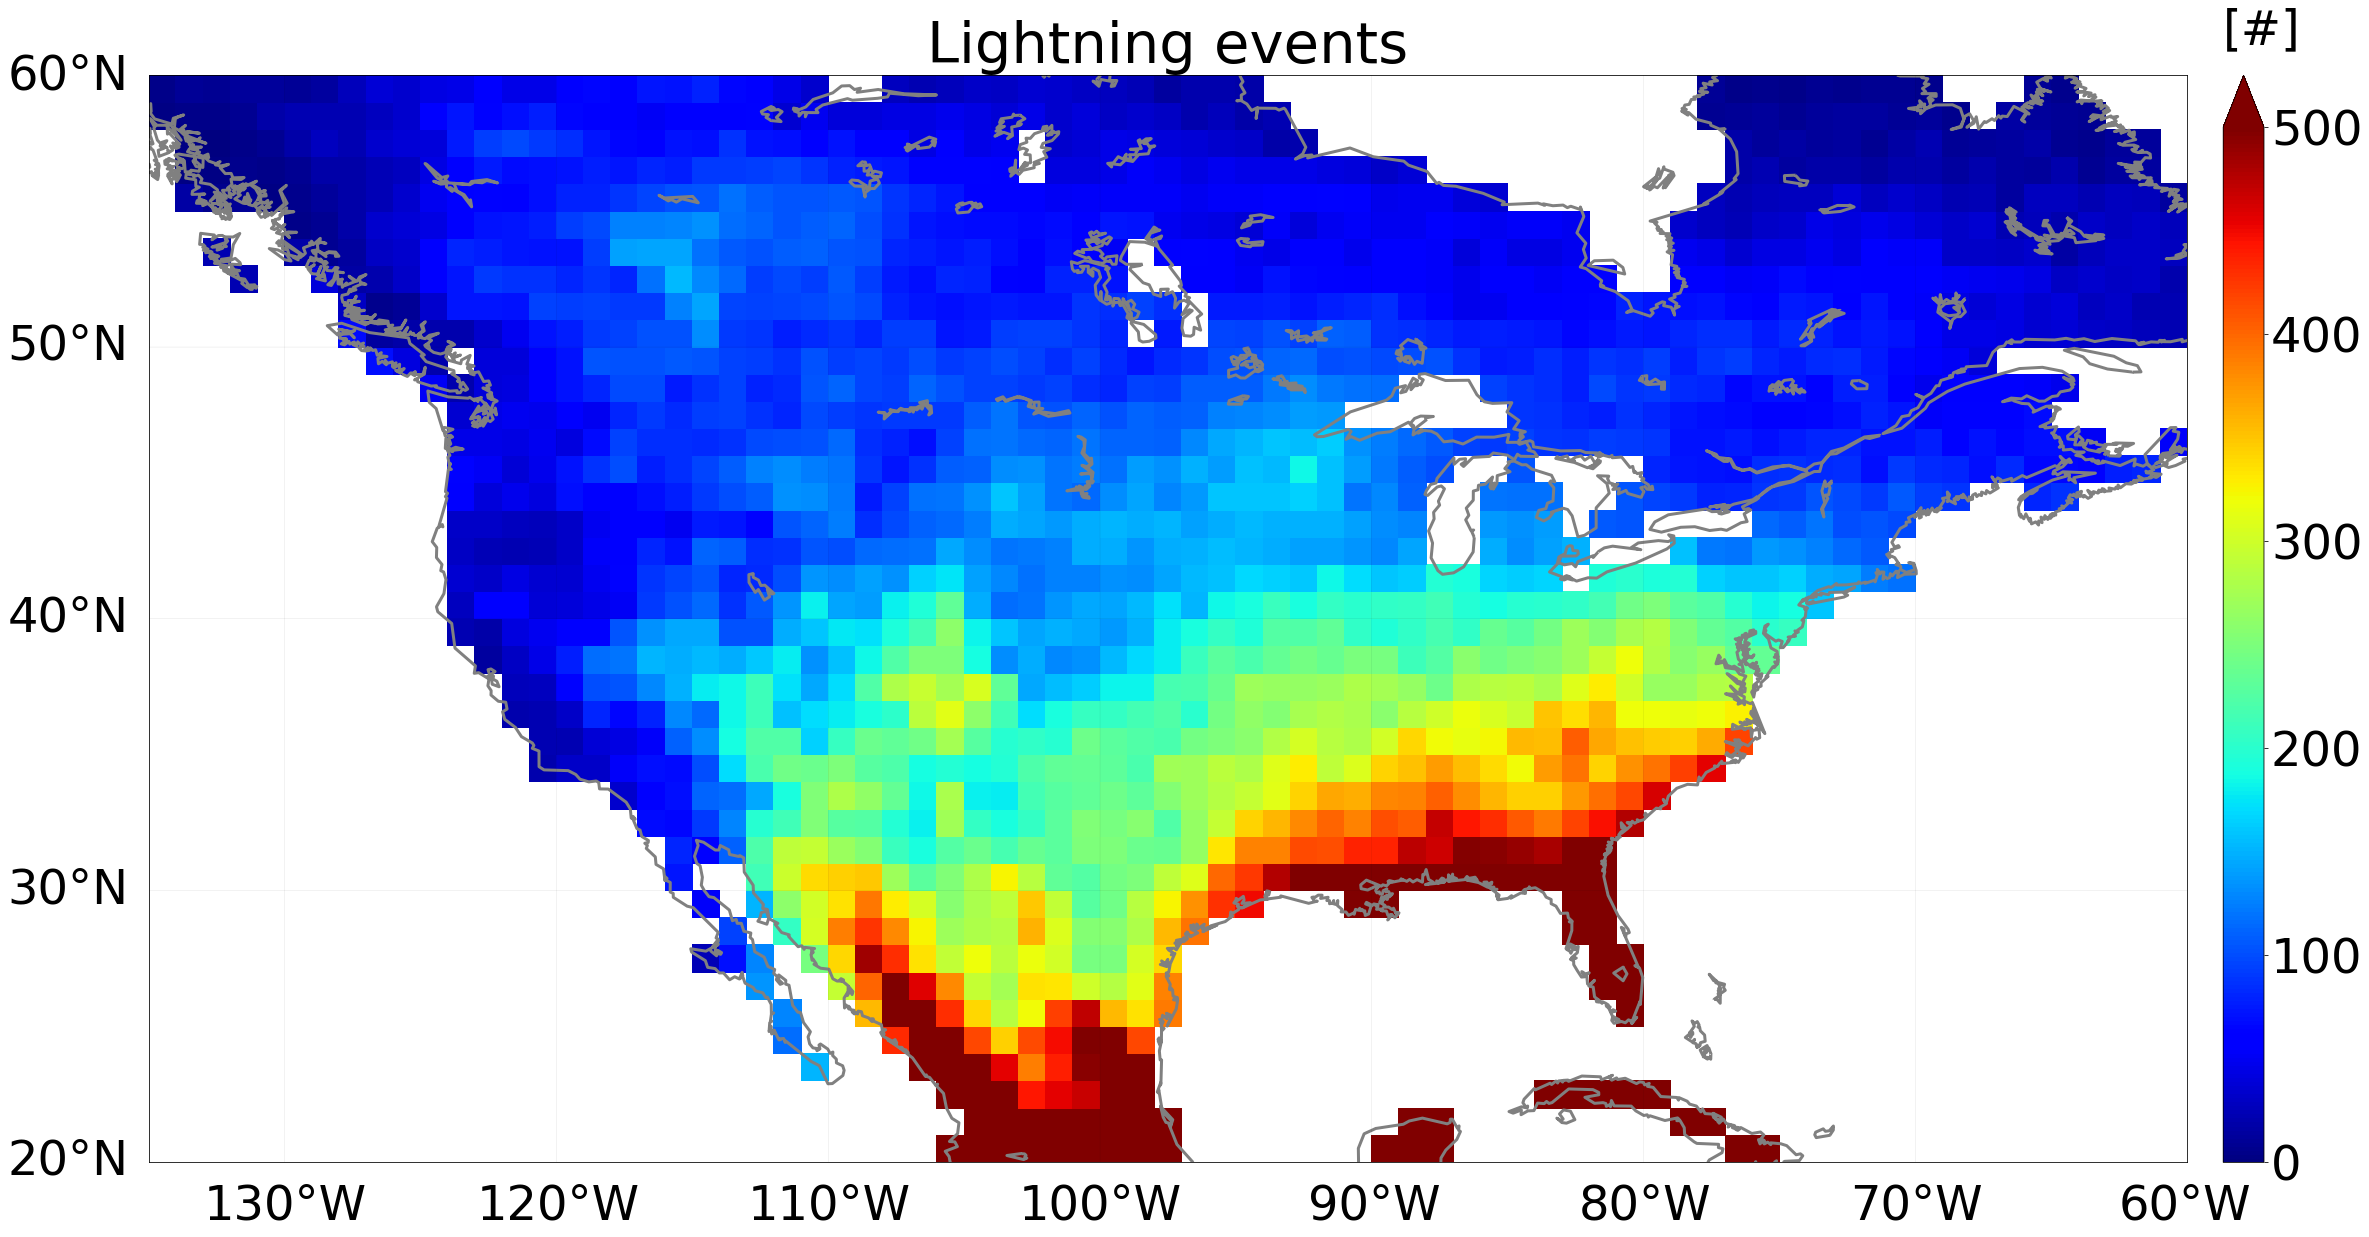

In [20]:
array = np.nansum((F_in>0)*mask_normal,axis=0)
F_normal = np.where(array==0,np.nan,array)
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(111)
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,resolution='l')
map.drawcoastlines(linewidth=coastlinewidth,color=coastlinecolor)
map.drawmeridians(np.arange(0,361,10),linewidth=0.1, labels=[0,0,0,1])
map.drawparallels(np.arange(-90,91,10), linewidth=0.1, labels=[1,0,0,0])
x, y = map(lons[:], lats[:])

cmap = plt.get_cmap('jet')
norm = BoundaryNorm(clevs0, ncolors=cmap.N, clip=True)
pcm  = plt.pcolormesh(x, y, F_normal, cmap=cmap, norm=mcolors.PowerNorm(1.0))
plt.clim(0,500)
plt.title('Lightning events')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.5)
cbar = plt.colorbar(pcm, cax=cax,extend='max')
plt.text(0,1.08,'[#]')


/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


Text(0, 1.08, '')

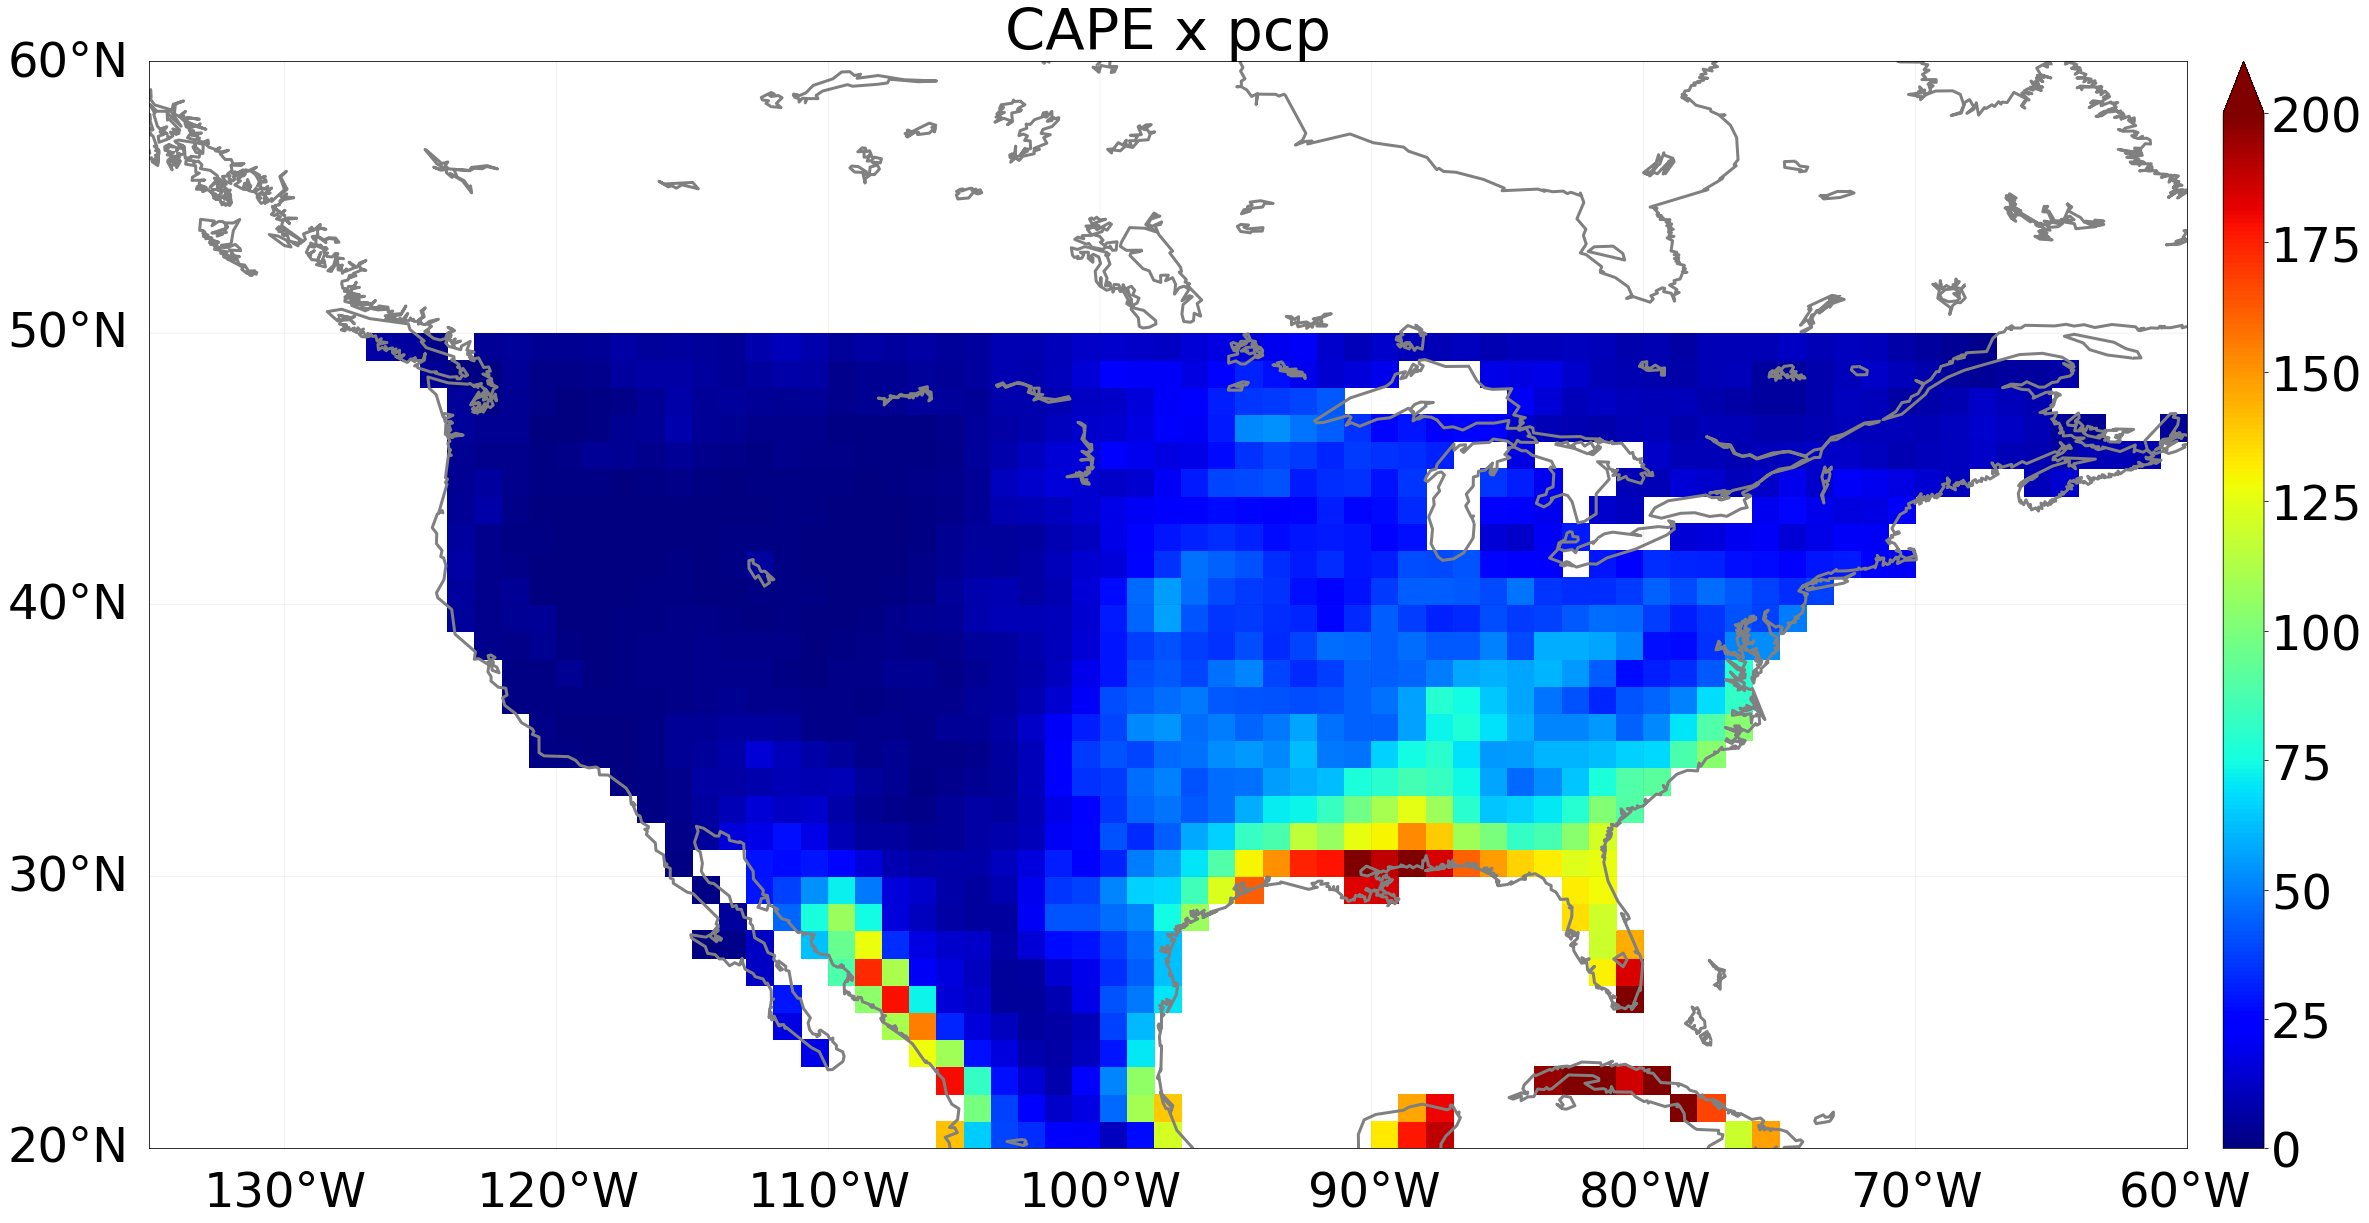

In [21]:
array = np.nanmean(cape_in*pcp_in*mask_normal,axis=0)[:,:]
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(111)
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,resolution='l')
map.drawcoastlines(linewidth=coastlinewidth,color=coastlinecolor)
map.drawmeridians(np.arange(0,361,10),linewidth=0.1, labels=[0,0,0,1])
map.drawparallels(np.arange(-90,91,10), linewidth=0.1, labels=[1,0,0,0])
x, y = map(lons[:], lats[:])

cmap = plt.get_cmap('jet')
norm = BoundaryNorm(clevs0, ncolors=cmap.N, clip=True)
pcm  = plt.pcolormesh(x, y, array, cmap=cmap, norm=mcolors.PowerNorm(1.0))
plt.clim(0,200)
plt.title('CAPE x pcp')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.5)
cbar = plt.colorbar(pcm, cax=cax,extend='max')
plt.text(0,1.08,'')


# Dry Thunderstorm

In [11]:
pcp_thrs      = 2.5/3
mask_pcpthrs  = pcp_in<pcp_thrs;
mask_dt       = 1.0*mask_pcpthrs*mask_island;
mask_dt       = np.where(mask_dt==0, np.nan, mask_dt);
print(mask_dt.shape)

(2928, 40, 75)


/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


(41, 76)


Text(0, 1.08, '[#]')

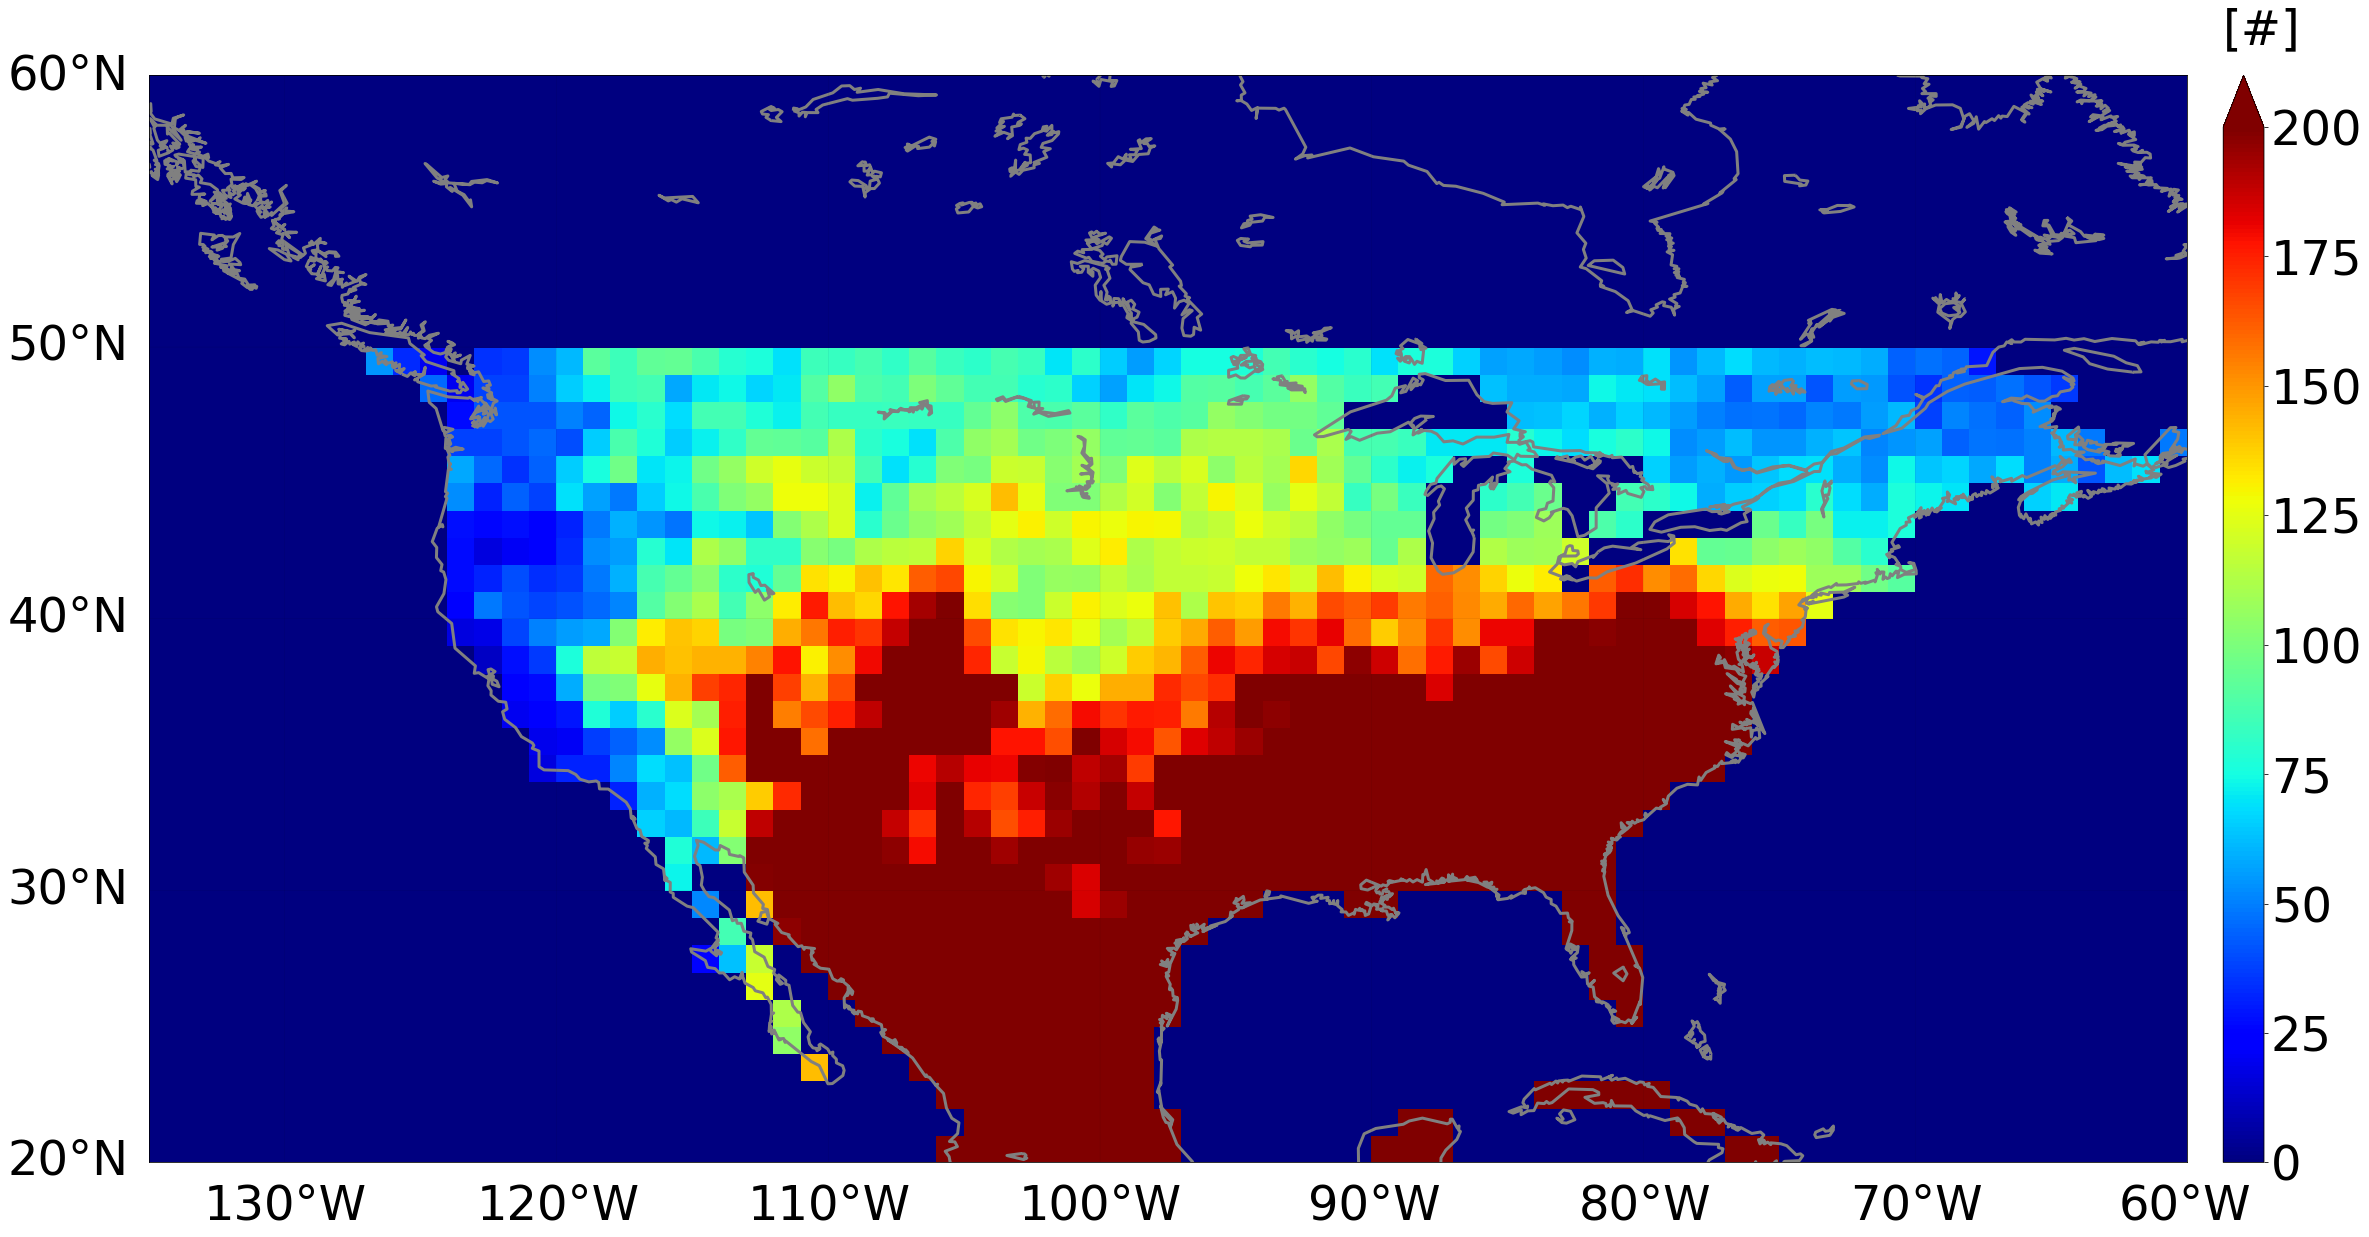

In [12]:
array = np.nansum((F_in>0)*mask_dt,axis=0)[:,:]
F_dry = array
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(111)
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,resolution='l')
map.drawcoastlines(linewidth=coastlinewidth,color=coastlinecolor)
#map.drawcountries(linewidth=0.25)
#map.drawmapboundary(fill_color='aqua')
map.drawmeridians(np.arange(0,361,10),linewidth=0.1, labels=[0,0,0,1])
map.drawparallels(np.arange(-90,91,10), linewidth=0.1, labels=[1,0,0,0])
# compute native map projection coordinates of lat/lon grid.
x, y = map(lons[:], lats[:])

print(x.shape)

cmap = plt.get_cmap('jet')
norm = BoundaryNorm(clevs0, ncolors=cmap.N, clip=True)
pcm  = plt.pcolormesh(x, y, array, cmap=cmap, norm=mcolors.PowerNorm(1.0))
#cs = map.contourf(x,y,np.sum(F_in,axis=0)/3,locator=ticker.LogLocator(), norm=mcolors.PowerNorm(0.1), range=[0, 1000000], cmap=plt.cm.jet,extend='both')
plt.clim(0,200)
plt.title('')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.5)
#plt.colorbar(cs, cax=cax)
cbar = plt.colorbar(pcm, cax=cax,extend='max')
#cbar.set_ticks([0,10,100,1000,10000,100000])
plt.text(0,1.08,'[#]')


/home/disk/p/wycheng/anaconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


(41, 76)


Text(0, 1.08, '[%]')

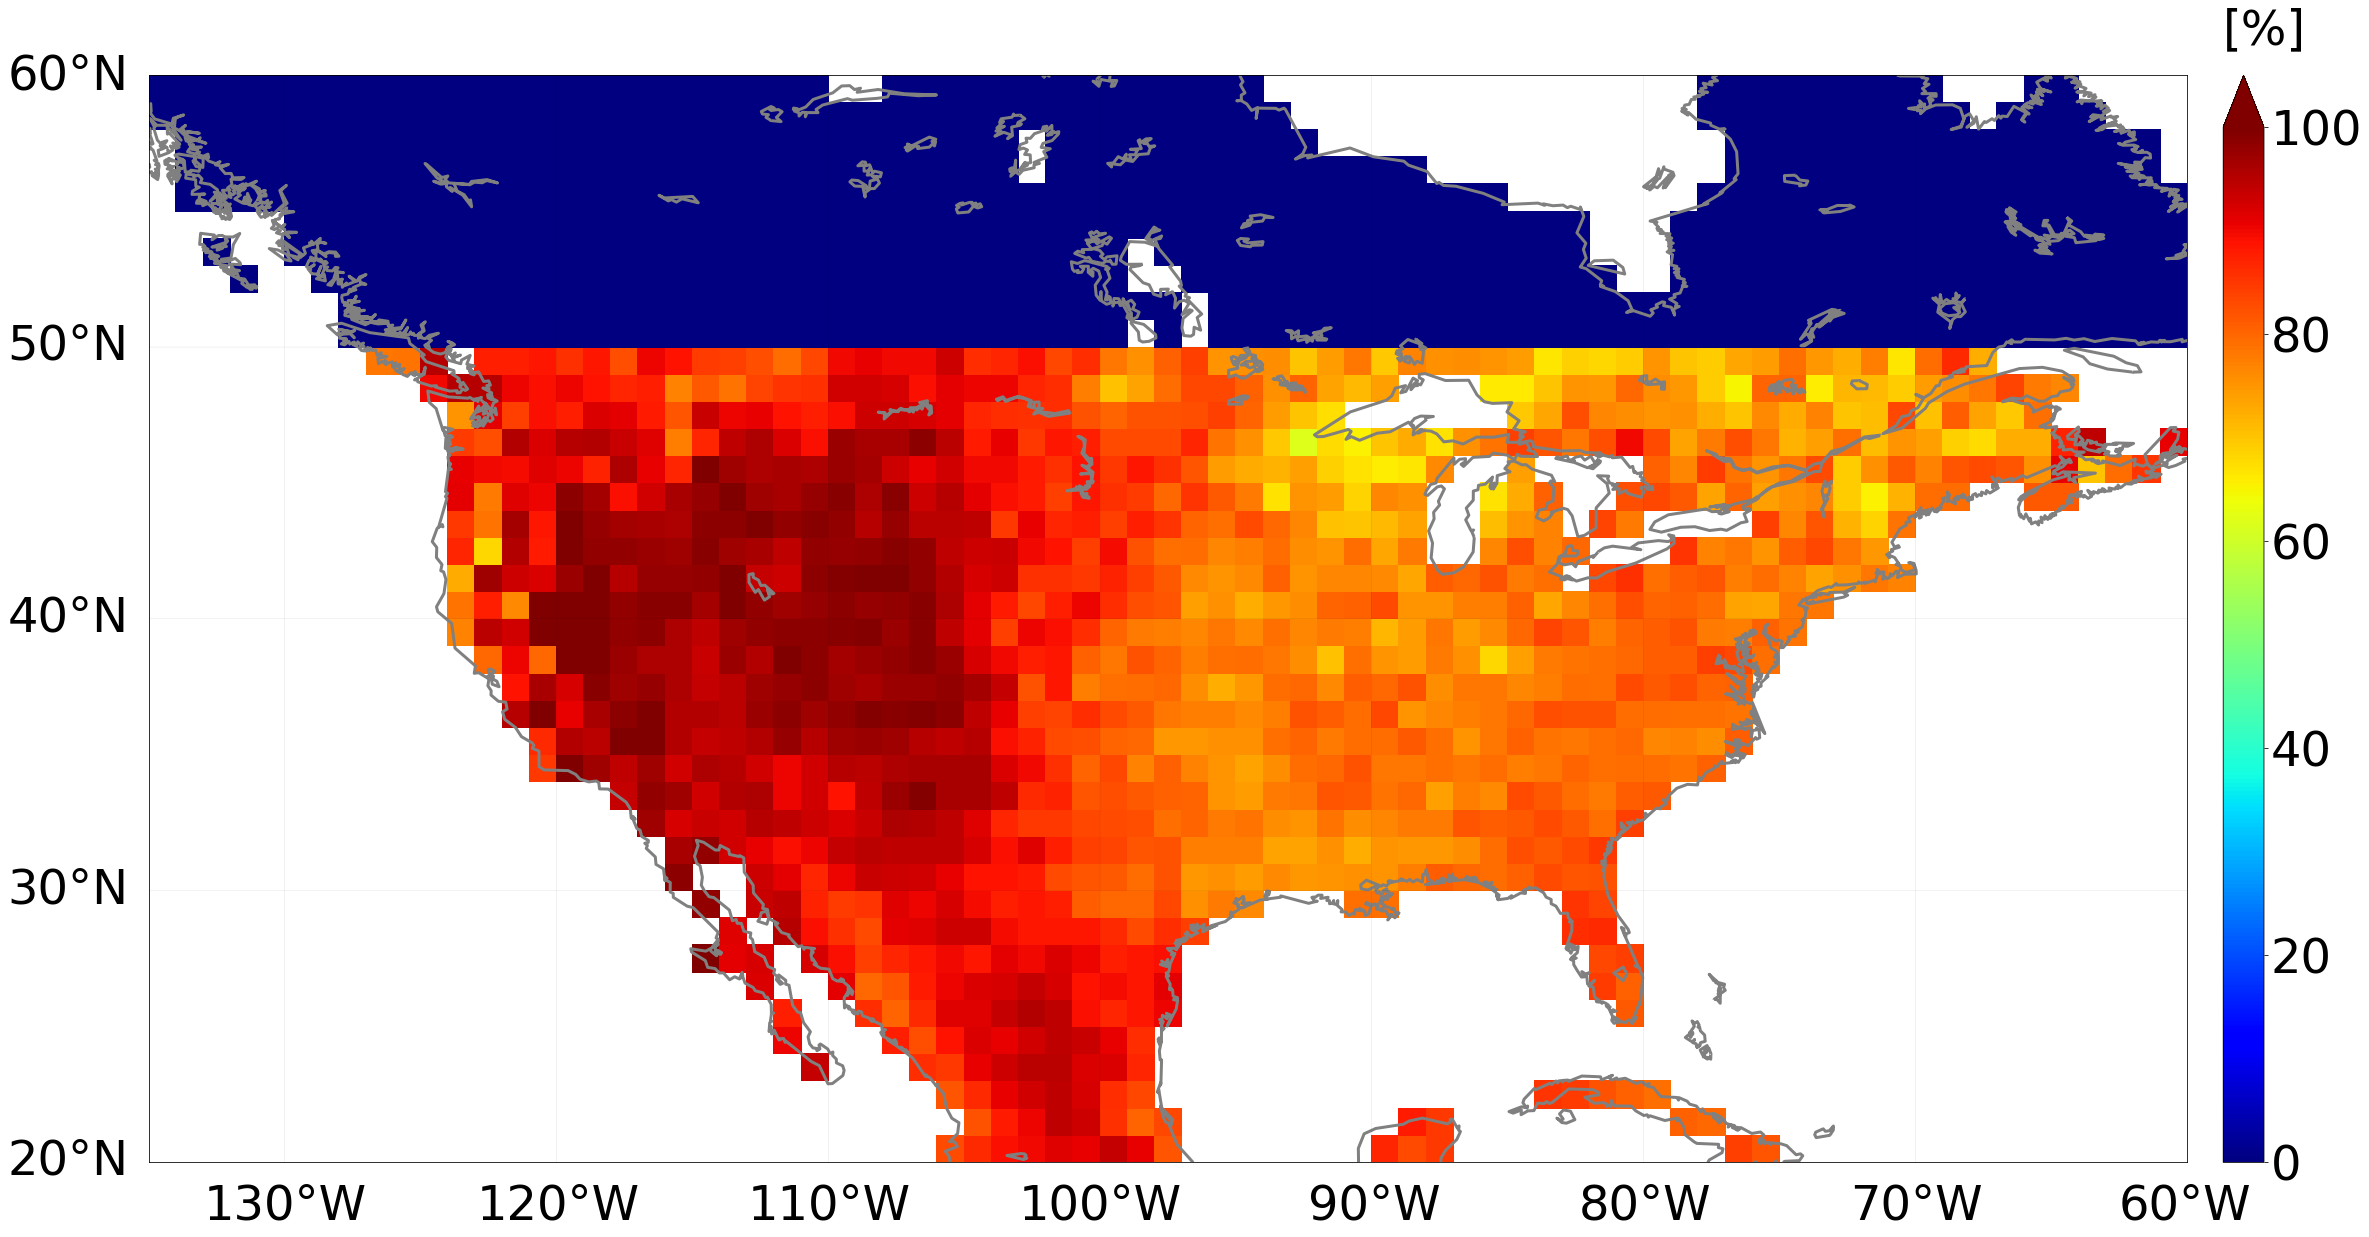

In [13]:
array = 100*np.where(F_normal>0, F_dry/F_normal , np.nan)
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(111)
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,resolution='l')
map.drawcoastlines(linewidth=coastlinewidth,color=coastlinecolor)
#map.drawcountries(linewidth=0.25)
#map.drawmapboundary(fill_color='aqua')
map.drawmeridians(np.arange(0,361,10),linewidth=0.1, labels=[0,0,0,1])
map.drawparallels(np.arange(-90,91,10), linewidth=0.1, labels=[1,0,0,0])
# compute native map projection coordinates of lat/lon grid.
x, y = map(lons[:], lats[:])

print(x.shape)

cmap = plt.get_cmap('jet')
norm = BoundaryNorm(clevs0, ncolors=cmap.N, clip=True)
pcm  = plt.pcolormesh(x, y, array, cmap=cmap, norm=mcolors.PowerNorm(1.0))
#cs = map.contourf(x,y,np.sum(F_in,axis=0)/3,locator=ticker.LogLocator(), norm=mcolors.PowerNorm(0.1), range=[0, 1000000], cmap=plt.cm.jet,extend='both')
plt.clim(0,100)
plt.title('')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.5)
#plt.colorbar(cs, cax=cax)
cbar = plt.colorbar(pcm, cax=cax,extend='max')
#cbar.set_ticks([0,10,100,1000,10000,100000])
plt.text(0,1.08,'[%]')
